## 2.1.1

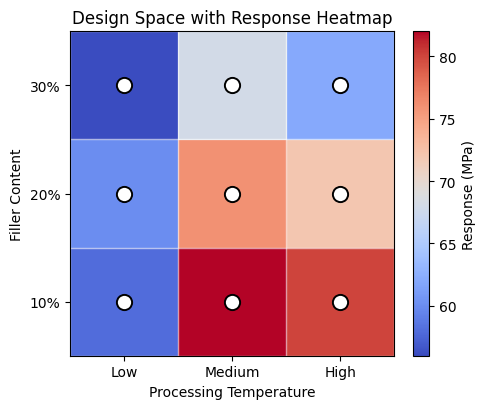

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# --- Fiktive Response-Werte in MPa (3x3), anpassbar ---
Z = np.array([
    [58, 82, 80],   # Filler 30 %  (oben)
    [60, 76, 72],   # Filler 20 %
    [56, 68, 62]    # Filler 10 %  (unten)
], dtype=float)

fig, ax = plt.subplots(figsize=(5.4, 4.2))

# Heatmap zeichnen
im = ax.imshow(Z, origin="lower", cmap="coolwarm",
               vmin=np.min(Z), vmax=np.max(Z))

# Ticks/Labels
ax.set_xticks([0, 1, 2], labels=["Low", "Medium", "High"])
ax.set_yticks([0, 1, 2], labels=["10%", "20%", "30%"])
ax.set_xlabel("Processing Temperature")
ax.set_ylabel("Filler Content")
ax.set_title("Design Space with Response Heatmap")

# Versuchs­punkte überlagern (weiße Kreise mit schwarzem Rand)
xg, yg = np.meshgrid([0, 1, 2], [0, 1, 2])
ax.scatter(xg.flatten(), yg.flatten(),
           s=120, facecolors="white", edgecolors="black",
           linewidths=1.4, zorder=3)

# optional: dezente Rasterlinien
ax.set_xticks([-.5, .5, 1.5, 2.5], minor=True)
ax.set_yticks([-.5, .5, 1.5, 2.5], minor=True)
ax.grid(which="minor", color="white", linewidth=1, alpha=0.6)
ax.tick_params(which="minor", length=0)

# Farbskala
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Response (MPa)")

plt.tight_layout()
plt.show()
# Export (druckfähig):
# plt.savefig("doe_designspace_heatmap.png", dpi=300, bbox_inches="tight")


## 2.1.2

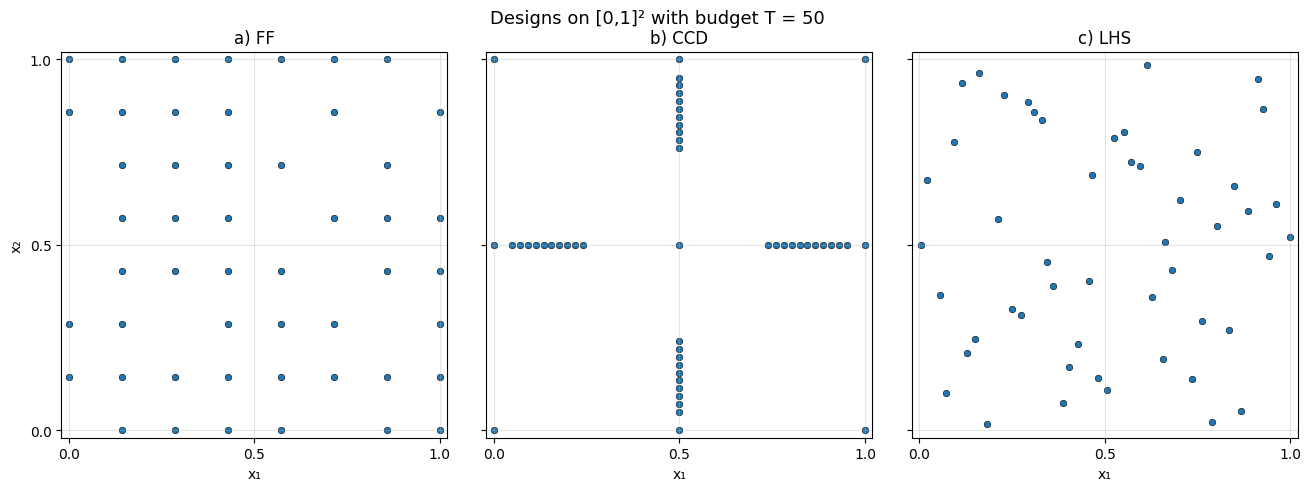

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil, sqrt

rng = np.random.default_rng(42)

def _ensure_unit_box(P):
    return np.clip(P, 0.0, 1.0)

def doe_ff_2d(B: int) -> np.ndarray:
    n = max(2, ceil(sqrt(B)))
    grid = np.linspace(0.0, 1.0, n)
    XX, YY = np.meshgrid(grid, grid, indexing="xy")
    P = np.column_stack([XX.ravel(), YY.ravel()])
    if len(P) > B:
        idx = rng.choice(len(P), size=B, replace=False)
        P = P[idx]
    return _ensure_unit_box(P)

def doe_ccd_2d(B: int) -> np.ndarray:
    center = np.array([[0.0, 0.0]])
    corners = np.array([[+1,+1],[+1,-1],[-1,+1],[-1,-1]])
    alpha_base = 1.0
    axial_base = np.array([[+alpha_base,0],[-alpha_base,0],[0,+alpha_base],[0,-alpha_base]])
    X = np.vstack([corners, axial_base, center])  # 9 points

    if B <= len(X):
        return _ensure_unit_box(0.5 * (X[:B] + 1.0))

    P_list = [0.5*(X + 1.0)]
    remaining = B - len(X)

    alphas = np.linspace(0.9, 0.1, 20)
    for a in alphas:
        if remaining <= 0:
            break
        ring = np.array([[+a,0],[-a,0],[0,+a],[0,-a]])
        P_ring = 0.5 * (ring + 1.0)
        take = min(4, remaining)
        P_list.append(P_ring[:take])
        remaining -= take

    if remaining > 0:
        jitter = (rng.random((remaining, 2)) - 0.5) * 0.02
        P_list.append(0.5 + jitter)

    P = np.vstack(P_list)
    return _ensure_unit_box(P[:B])

def doe_lhs_2d(B: int) -> np.ndarray:
    x = (rng.random(B) + np.arange(B)) / B
    y = (rng.random(B) + rng.permutation(B)) / B
    return _ensure_unit_box(np.column_stack([x, y]))

def plot_b50_side_by_side(figsize=(13.2, 4.6), s=22, savepath="Fig_DOE_FF_CCD_LHS_B50.png"):
    B = 50
    designs = [
        ("a) FF",  doe_ff_2d(B)),
        ("b) CCD", doe_ccd_2d(B)),
        ("c) LHS", doe_lhs_2d(B)),
    ]

    fig, axes = plt.subplots(1, 3, figsize=figsize, constrained_layout=True)

    for k, (ax, (title, P)) in enumerate(zip(axes, designs)):
        ax.scatter(P[:,0], P[:,1], s=s, edgecolor="k", linewidth=0.4)
        ax.set_xlim(-0.02, 1.02)
        ax.set_ylim(-0.02, 1.02)
        ax.set_aspect("equal", adjustable="box")
        ax.grid(True, alpha=0.35)
        ax.set_xticks([0, 0.5, 1.0]); ax.set_yticks([0, 0.5, 1.0])
        ax.set_xlabel("x₁")
        if k == 0:
            ax.set_ylabel("x₂")
        else:
            ax.set_ylabel("")
            ax.tick_params(labelleft=False)  # hide y tick labels on b) and c)
        ax.set_title(title)

    # English header without method names and with a touch more space
    fig.suptitle("Designs on [0,1]² with budget T = 50", y=1.035, fontsize=13)
    # fig.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()
    return savepath

if __name__ == "__main__":
    plot_b50_side_by_side()


### 2.2.2

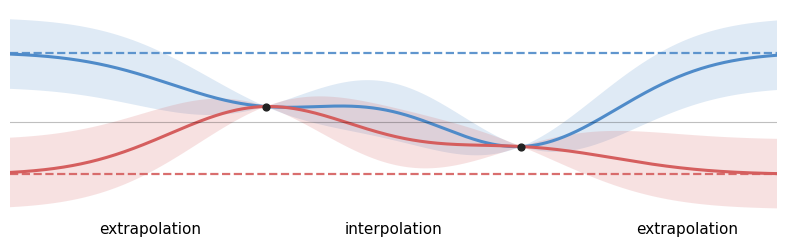

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Farben
BLUE = "#4F8BC9"
RED  = "#D55E5E"
GRAY = "#222222"

# --- Daten & Auswerte-Grid ---
X = np.array([[-1.0],[1.0]])          # zwei Beobachtungen
y = np.array([0.18, -0.28])              # beide = 0
xs = np.linspace(-3, 3, 800)[:,None]

# --- RBF/SE-Kernel: K(a,b) = sigma_f^2 * exp(-0.5 * d^2 / ell^2)
def rbf_kernel(a, b, ell=0.75, sigma_f=0.20):  # kürzeres ell + kleinere sigma_f -> Bauch größer
    d2 = (a - b.T)**2
    return (sigma_f**2) * np.exp(-0.5 * d2 / (ell**2))

K_xx   = rbf_kernel(X, X)
K_xxs  = rbf_kernel(X, xs)
K_xsx  = K_xxs.T
K_xsxs = rbf_kernel(xs, xs)

# --- sehr kleines Rauschen -> exakte Interpolation in den Punkten ---
sigma_n = 1e-9
Ky = K_xx + (sigma_n**2) * np.eye(len(X))
L  = np.linalg.cholesky(Ky)
solveKy = lambda v: np.linalg.solve(L.T, np.linalg.solve(L, v))

# --- zwei unterschiedliche Prior-Mittel (nur hier unterscheiden sich die GPs) ---
m0_blue_val =  +0.80
m0_red_val  =  -0.60
m0_blue = m0_blue_val * np.ones_like(xs)
m0_red  = m0_red_val  * np.ones_like(xs)
m0_blue_X = m0_blue_val * np.ones_like(X)
m0_red_X  = m0_red_val  * np.ones_like(X)

# --- Posterior-Mittel (gehen mit sigma_n->0 exakt durch die Punkte) ---
alpha_blue = solveKy((y - m0_blue_X.ravel())[:,None])  # (n,1)
alpha_red  = solveKy((y - m0_red_X .ravel())[:,None])
m_blue = m0_blue + K_xsx @ alpha_blue
m_red  = m0_red  + K_xsx @ alpha_red

# --- Posterior-Varianz (gemeinsam für beide, da Ky identisch) ---
A  = solveKy(K_xxs)                     # Ky^{-1} K(X,xs)
s2 = np.maximum(0.0, np.diag(K_xsxs - K_xsx @ A)[:,None])
s  = np.sqrt(s2)

# --- Plot ---
plt.rcParams.update({"figure.figsize": (8, 2.6), "font.size": 11})
fig, ax = plt.subplots()

# Unsicherheitsbänder (klein zwischen den Punkten, groß außerhalb)
ax.fill_between(xs.ravel(), (m_blue - 2*s).ravel(), (m_blue + 2*s).ravel(),
                color=BLUE, alpha=0.18, edgecolor="none")
ax.fill_between(xs.ravel(), (m_red  - 2*s).ravel(), (m_red  + 2*s).ravel(),
                color=RED,  alpha=0.18, edgecolor="none")

# Posterior-Mittel (gehen exakt durch die Punkte)
ax.plot(xs, m_blue, color=BLUE, lw=2.2)
ax.plot(xs, m_red,  color=RED,  lw=2.2)

# Prior-Mittel (gestrichelt, horizontal)
ax.hlines(m0_blue_val, xs.min(), xs.max(), colors=BLUE, linestyles="--", linewidth=1.6, alpha=0.9)
ax.hlines(m0_red_val,  xs.min(), xs.max(), colors=RED,  linestyles="--", linewidth=1.6, alpha=0.9)

# Punkte
ax.scatter(X.ravel(), y, s=24, color=GRAY, zorder=5)

# Beschriftungen unten
yl = ax.get_ylim()
ax.text(-2.3, yl[0] - 0.02*(yl[1]-yl[0]), "extrapolation", ha="left", va="top")
ax.text( 0.00, yl[0] - 0.02*(yl[1]-yl[0]), "interpolation", ha="center", va="top")
ax.text( 1.9,  yl[0] - 0.02*(yl[1]-yl[0]), "extrapolation", ha="left", va="top")

# Optik
ax.set_xlim(-3, 3)
ax.set_xticks([]); ax.set_yticks([])
for s in ["top","right","left","bottom"]:
    ax.spines[s].set_visible(False)
ax.axhline(0.0, color="#000000", lw=0.8, alpha=0.25)

plt.tight_layout()
plt.show()
# plt.savefig("gp_prior_influence_mean_gp_belly.png", dpi=300, bbox_inches="tight")


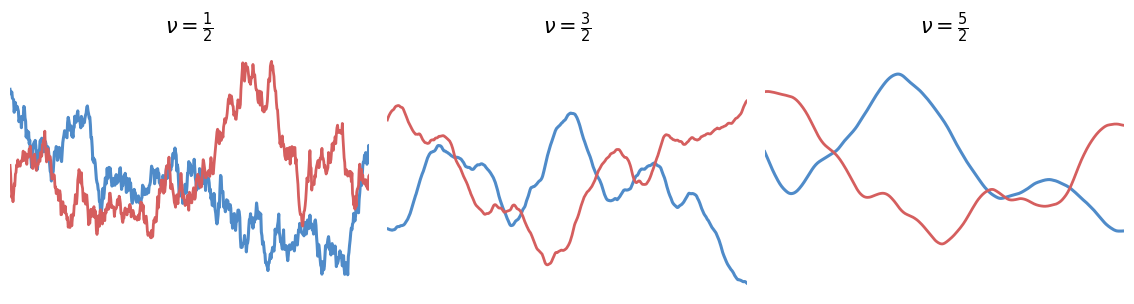

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Reproduzierbarkeit
rs = np.random.RandomState(7)

# Farben (konsistent)
BLUE = "#4F8BC9"
RED  = "#D55E5E"

# Matérn-Kerne für ν = 1/2, 3/2, 5/2
def matern(r, ell, sigma_f, nu):
    r = np.asarray(r)
    if nu == 0.5:
        return sigma_f**2 * np.exp(-r/ell)
    elif nu == 1.5:
        s = np.sqrt(3)*r/ell
        return sigma_f**2 * (1.0 + s) * np.exp(-s)
    elif nu == 2.5:
        s = np.sqrt(5)*r/ell
        return sigma_f**2 * (1.0 + s + 5.0*r**2/(3.0*ell**2)) * np.exp(-s)
    else:
        raise ValueError("This snippet implements ν ∈ {0.5, 1.5, 2.5}.")

def cov_matrix(x, ell, sigma_f, nu):
    x = x[:, None]
    r = np.abs(x - x.T)
    return matern(r, ell, sigma_f, nu) + 1e-10*np.eye(len(x))  # jitter

# Diskretisierung (x-Achse)
n = 600
x = np.linspace(0, 1, n)

# Gemeinsame Hyperparameter (gleiches ℓ für fairen Vergleich)
ell = 0.15
sigma_f = 1.0

# Cholesky-Sampling aus N(0, K)
def gp_sample(x, ell, sigma_f, nu, rs):
    K = cov_matrix(x, ell, sigma_f, nu)
    L = np.linalg.cholesky(K)
    z = rs.randn(len(x))
    return L @ z

# Pfade erzeugen
paths = {
    0.5: (gp_sample(x, ell, sigma_f, 0.5, rs), gp_sample(x, ell, sigma_f, 0.5, rs)),
    1.5: (gp_sample(x, ell, sigma_f, 1.5, rs), gp_sample(x, ell, sigma_f, 1.5, rs)),
    2.5: (gp_sample(x, ell, sigma_f, 2.5, rs), gp_sample(x, ell, sigma_f, 2.5, rs)),
}

# ... dein Code oben ...

# Größere Standardschrift + größere Achsentitel
import matplotlib as mpl
mpl.rcParams.update({
    "figure.figsize": (11.5, 3.2),   # etwas breiter
    "font.size": 12,                 # Grundschrift größer
    "axes.titlesize": 15,            # Titelgröße (ν=…)
})

fig, axes = plt.subplots(1, 3, sharey=True)

# Mehr Platz zwischen den Subplots
fig.subplots_adjust(left=0.04, right=0.98, top=0.88, bottom=0.10, wspace=0.40)

labels = {
    0.5: r"$\nu = \frac{1}{2}$",
    1.5: r"$\nu = \frac{3}{2}$",
    2.5: r"$\nu = \frac{5}{2}$",
}

for ax, nu in zip(axes, [0.5, 1.5, 2.5]):
    y1, y2 = paths[nu]
    s = max(np.std(y1), np.std(y2)); y1 /= s; y2 /= s
    ax.plot(x, y1, color=BLUE, lw=2.2)
    ax.plot(x, y2, color=RED,  lw=2.0)
    ax.set_xticks([]); ax.set_yticks([])
    for sp in ["top","right","left","bottom"]:
        ax.spines[sp].set_visible(False)
    ax.set_xlim(0, 1)
    ax.set_title(labels[nu], fontsize=15, pad=12)   # Titel zusätzlich direkt größer setzen


plt.tight_layout()
plt.show()
# plt.savefig("matern_samples_nu_051525.png", dpi=300, bbox_inches="tight")


## 2.2.3

C:\Users\marti\AppData\Local\Temp\ipykernel_21808\220332754.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


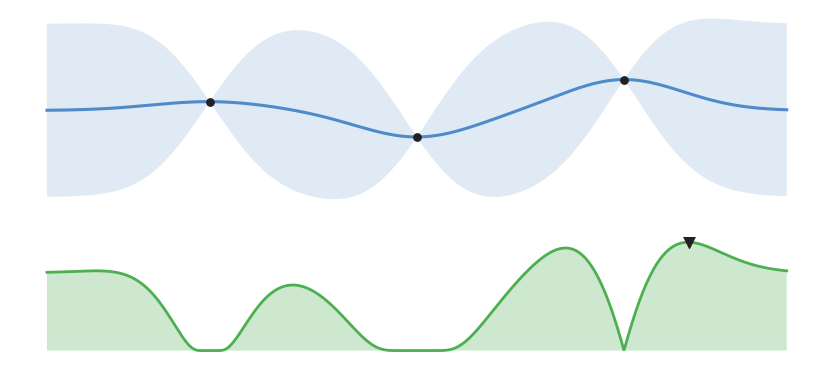

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.spatial.distance import cdist

# ===== Farben =====
BLUE  = "#4F8BC9"   # Posterior
GREEN = "#4CAF50"   # EI

# ===== Kernel (RBF) -> kürzere ell => steilere/engere Strukturen =====
def rbf_kernel(x1, x2, lengthscale=0.8, variance=1.0):
    d = cdist(x1, x2, metric="euclidean")
    return variance * np.exp(-0.5 * (d/lengthscale)**2)

# ===== Domain & Daten =====
X = np.linspace(0, 10, 800).reshape(-1, 1)
Xtr = np.array([[2.2], [5.0], [7.8]])
ytr = np.array([0.2, -0.6, 0.7])

# ===== GP-Posterior =====
K_xx = rbf_kernel(Xtr, Xtr)
K_xX = rbf_kernel(Xtr, X)
K_XX = rbf_kernel(X, X)
K_inv = np.linalg.inv(K_xx + 1e-6*np.eye(len(Xtr)))

mu = (K_xX.T @ K_inv @ ytr).ravel()
cov = K_XX - K_xX.T @ K_inv @ K_xX
sd  = np.sqrt(np.clip(np.diag(cov), 0.0, np.inf))

# ===== Expected Improvement (EI) =====
y_best = np.max(ytr)  # exploitation an beobachteten Bestwert gebunden
eps = 1e-12
Z = (mu - y_best) / np.maximum(sd, eps)
ei = (mu - y_best) * norm.cdf(Z) + sd * norm.pdf(Z)
ei[sd <= 1e-15] = 0.0

# EI-Maximum
i_max = int(np.argmax(ei))
x_next, ei_next = X[i_max, 0], ei[i_max]

# ===== Plot (oben Posterior, unten EI) =====
plt.rcParams.update({"figure.figsize": (10.5, 4.5), "font.size": 11})
fig = plt.figure()
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1.8], hspace=0.18)

# Oberes Panel: Posterior
ax1 = fig.add_subplot(gs[0, 0])
ax1.fill_between(X.ravel(), mu - 1.96*sd, mu + 1.96*sd,
                 color=BLUE, alpha=0.18, edgecolor="none")
ax1.plot(X, mu, color=BLUE, lw=2.2)
ax1.scatter(Xtr.ravel(), ytr, s=28, c="#222222", zorder=5)

ax1.set_xticks([]); ax1.set_yticks([])
for s in ["top","right","left","bottom"]:
    ax1.spines[s].set_visible(False)

# Unteres Panel: EI (grün, blasser fill, grüne Outline)
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax2.fill_between(X.ravel(), 0.0, ei, color=GREEN, alpha=0.28, edgecolor="none")
ax2.plot(X, ei, color=GREEN, lw=2.0)             # grüne Outline
ax2.scatter([x_next], [ei_next], marker="v", s=70, c="#222222", zorder=6)  # Marker

ax2.set_xticks([]); ax2.set_yticks([])
for s in ["top","right","left","bottom"]:
    ax2.spines[s].set_visible(False)

plt.tight_layout()
plt.show()
# plt.savefig("bo_ei_policy_green.png", dpi=300, bbox_inches="tight")


## 2.3

In [1]:
#%matplotlib widget
import ipywidgets as widgets  # optional, but good to have


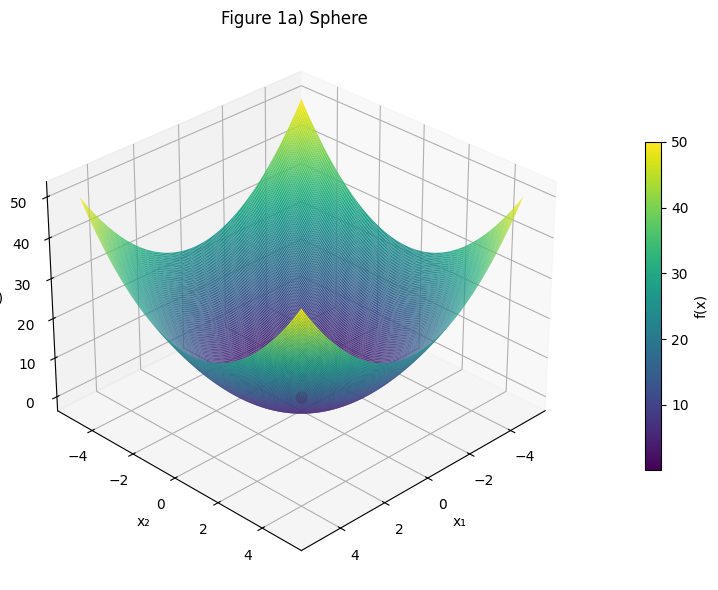

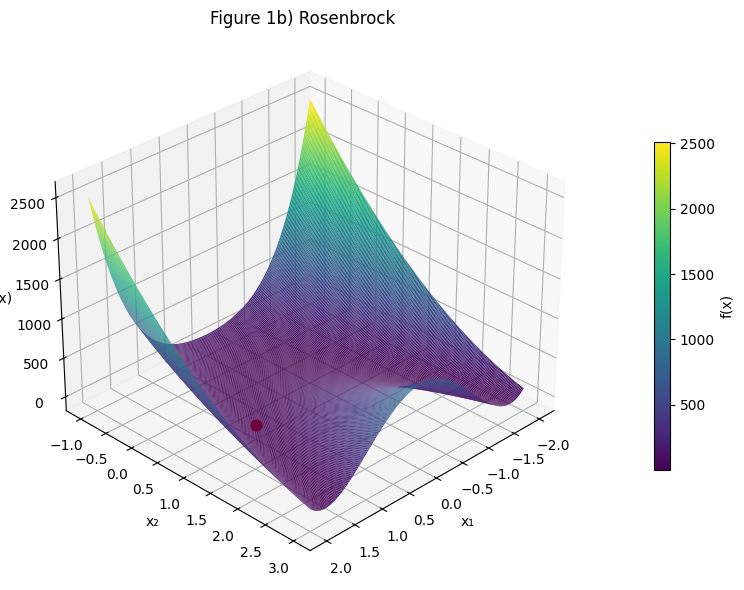

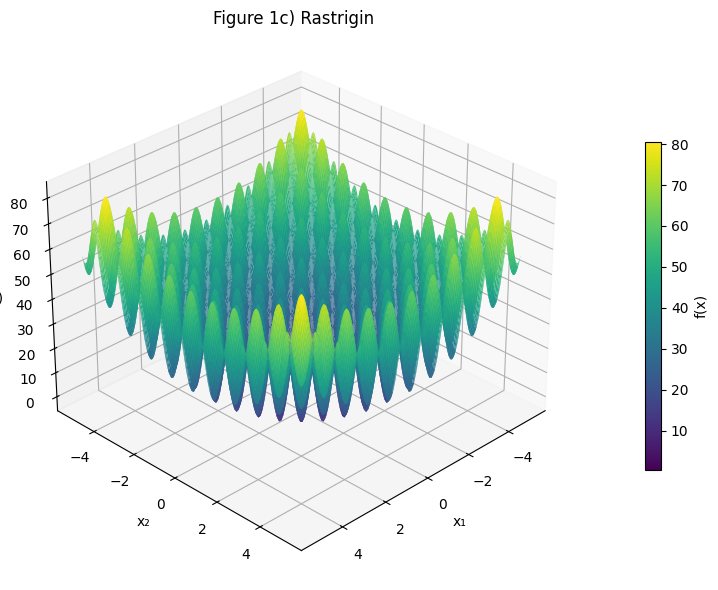

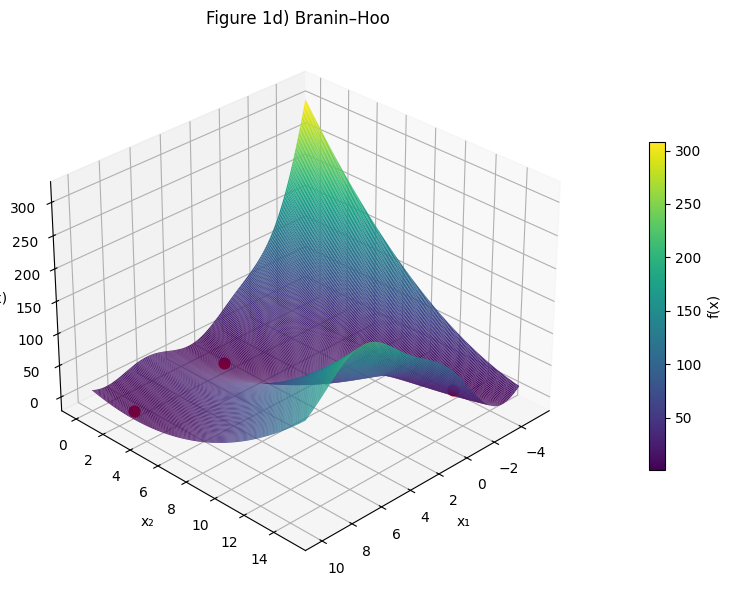

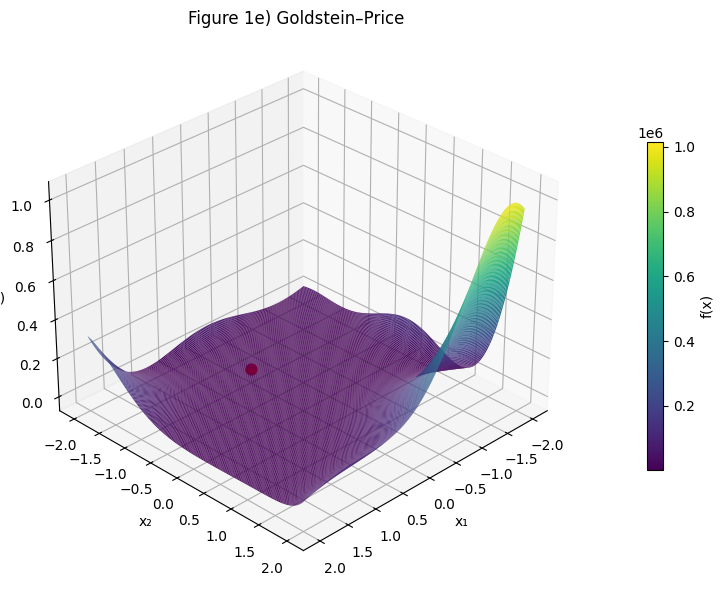

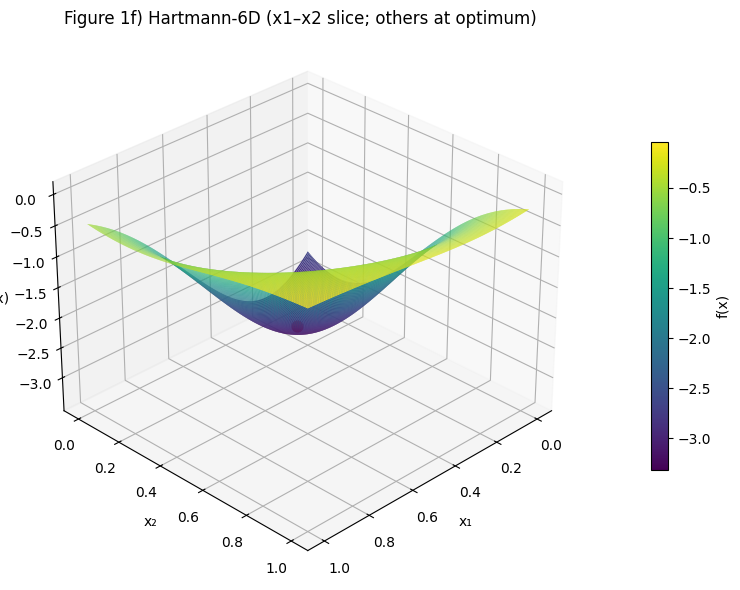

In [2]:
# Re-plot 3D surfaces for the selected benchmark functions
# (Sphere, Rosenbrock, Rastrigin, Branin–Hoo, Goldstein–Price, Hartmann-6D slice)
# - Global minima marked in red
# - Surface facecolors vary with z (height / f(x))

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa
from matplotlib import cm
from matplotlib.colors import Normalize

def sphere(x, y):
    return x**2 + y**2

def rosenbrock(x, y, a=1, b=100):
    return (a - x)**2 + b*(y - x**2)**2

def rastrigin(x, y):
    return 20 + (x**2 - 10*np.cos(2*np.pi*x)) + (y**2 - 10*np.cos(2*np.pi*y))

def branin(x, y):
    a = 1.0
    b = 5.1/(4*np.pi**2)
    c = 5/np.pi
    r = 6
    s = 10
    t = 1/(8*np.pi)
    return a*(y - b*x**2 + c*x - r)**2 + s*(1 - t)*np.cos(x) + s

def goldstein_price(x, y):
    term1 = 1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)
    term2 = 30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2)
    return term1 * term2

# Hartmann-6D – 2D slice (x1,x2 vary), x3..x6 fixed at known optimum
def hartmann6_xy(x, y, x3=0.476874, x4=0.275332, x5=0.311652, x6=0.657300):
    alpha = np.array([1.0, 1.2, 3.0, 3.2])
    A = np.array([
        [10.0,  3.0, 17.0, 3.5,  1.7,  8.0],
        [ 0.05,10.0, 17.0, 0.1,  8.0, 14.0],
        [ 3.0,  3.5,  1.7,10.0, 17.0,  8.0],
        [17.0,  8.0,  0.05,10.0, 0.1, 14.0]
    ])
    P = 1e-4 * np.array([
        [1312, 1696, 5569,  124, 8283, 5886],
        [2329, 4135, 8307, 3736,  1004, 9991],
        [2348, 1451, 3522, 2883,  3047, 6650],
        [4047, 8828, 8732, 5743,  1091,  381]
    ])

    X1 = x
    X2 = y
    X3 = np.full_like(X1, x3)
    X4 = np.full_like(X1, x4)
    X5 = np.full_like(X1, x5)
    X6 = np.full_like(X1, x6)
    X = np.stack([X1, X2, X3, X4, X5, X6], axis=-1)

    inner = np.sum(A[None, :, :] * (X[..., None, :] - P[None, :, :])**2, axis=-1)  # (..., 4)
    return -np.sum(alpha[None, :] * np.exp(-inner), axis=-1)

# --- Plot configuration: domains and known global minima ---
plots = [
    ("Figure 1a) Sphere", (-5.0, 5.0, -5.0, 5.0), sphere, [(0.0, 0.0)]),
    ("Figure 1b) Rosenbrock", (-2.0, 2.0, -1.0, 3.0), rosenbrock, [(1.0, 1.0)]),
    ("Figure 1c) Rastrigin", (-5.12, 5.12, -5.12, 5.12), rastrigin, [(0.0, 0.0)]),
    ("Figure 1d) Branin–Hoo", (-5.0, 10.0, 0.0, 15.0), branin,
     [(-np.pi, 12.275), (np.pi, 2.275), (9.42478, 2.475)]),
    ("Figure 1e) Goldstein–Price", (-2.0, 2.0, -2.0, 2.0), goldstein_price, [(0.0, -1.0)]),
    ("Figure 1f) Hartmann-6D (x1–x2 slice; others at optimum)", (0.0, 1.0, 0.0, 1.0),
     hartmann6_xy, [(0.20169, 0.150011)]),
]

# Colormap normalized by z (f(x)) for facecolors
def surface_with_z_gradient(ax, XX, YY, ZZ):
    norm = Normalize(vmin=ZZ.min(), vmax=ZZ.max())
    cmap = cm.viridis
    facecolors = cmap(norm(ZZ))
    surf = ax.plot_surface(
        XX, YY, ZZ,
        rstride=1, cstride=1,
        facecolors=facecolors,
        linewidth=0, antialiased=True,
        shade=False  # ensures color reflects ZZ only (no lighting)
    )
    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array(ZZ)
    plt.colorbar(mappable, ax=ax, shrink=0.6, pad=0.1, label="f(x)")
    return surf

# --- Render all plots ---
for title, (xmin, xmax, ymin, ymax), f, minima in plots:
    X = np.linspace(xmin, xmax, 200)
    Y = np.linspace(ymin, ymax, 200)
    XX, YY = np.meshgrid(X, Y)
    ZZ = f(XX, YY)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    surface_with_z_gradient(ax, XX, YY, ZZ)

    # Mark global minima in red
    for (xm, ym) in minima:
        zm = f(np.array(xm, dtype=float), np.array(ym, dtype=float))
        ax.scatter([xm], [ym], [zm], color='red', s=60, depthshade=False)

    ax.set_title(title)
    ax.set_xlabel("x₁")
    ax.set_ylabel("x₂")
    ax.set_zlabel("f(x)")
    ax.view_init(elev=30, azim=45)
    plt.tight_layout()
    plt.show()


## 2.4

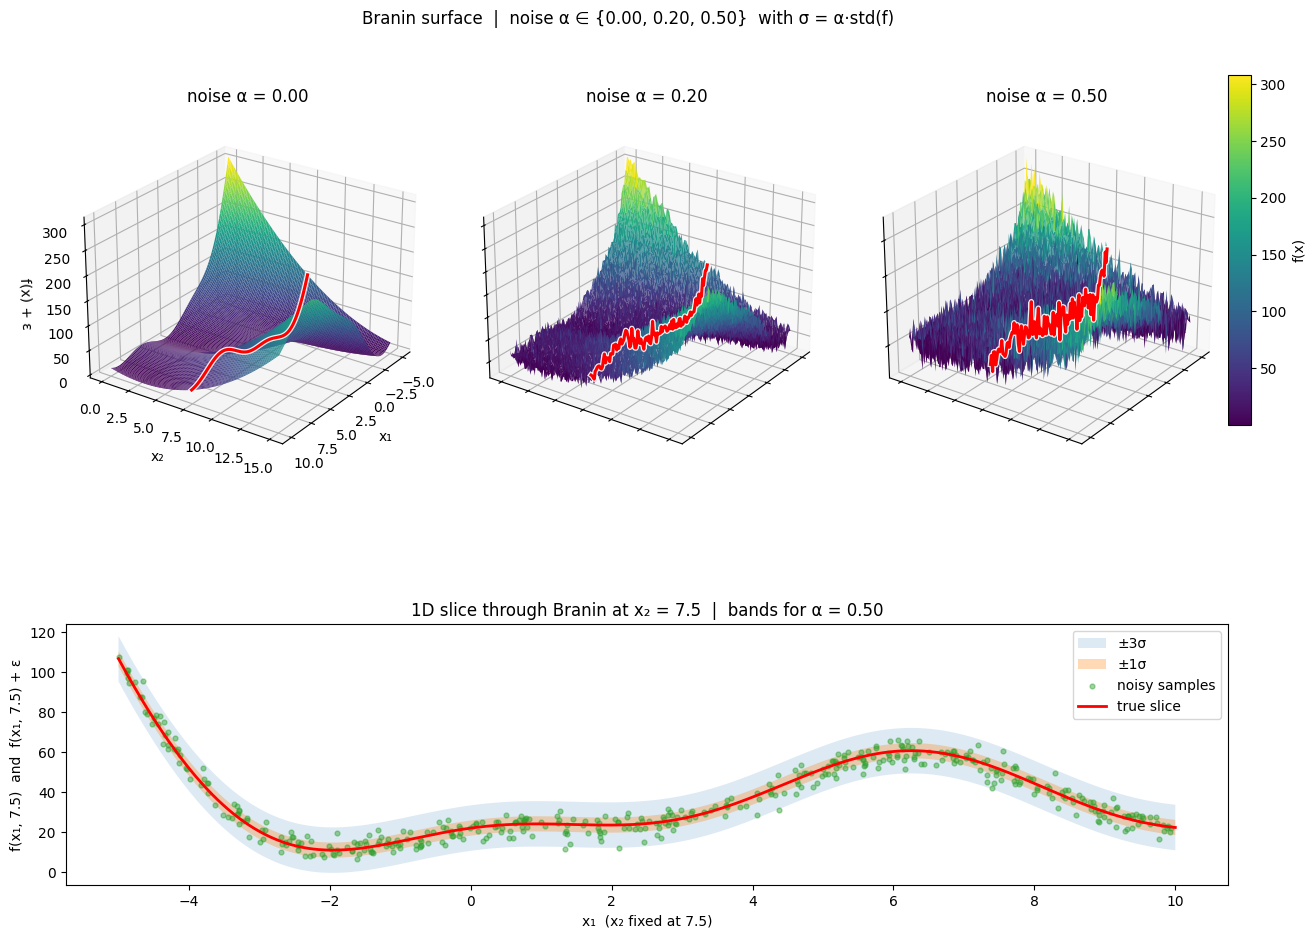

In [ ]:
# Two-row panel with a single right-side colorbar, tighter title spacing,
# and grids also on the unlabeled 3D axes.

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from matplotlib import cm
from matplotlib.colors import Normalize

def branin(x, y):
    a = 1.0
    b = 5.1 / (4 * np.pi**2)
    c = 5 / np.pi
    r = 6.0
    s = 10.0
    t = 1.0 / (8 * np.pi)
    return a * (y - b * x**2 + c * x - r)**2 + s * (1 - t) * np.cos(x) + s

# Surface grid
nx = ny = 120
x = np.linspace(-5.0, 10.0, nx)
y = np.linspace(0.0, 15.0, ny)
X, Y = np.meshgrid(x, y)
Z_true = branin(X, Y)

# Shared color normalization
norm = Normalize(vmin=float(np.nanmin(Z_true)), vmax=float(np.nanmax(Z_true)))
cmap = cm.viridis

# Noise levels
alphas = [0.00, 0.20, 0.50]
rng = np.random.default_rng(12345)
stdZ = float(np.nanstd(Z_true))

# Slice to highlight
y_fixed = 7.5
j_slice = int(np.argmin(np.abs(y - y_fixed)))  # nearest index to 7.5
y_line = np.full_like(x, y[j_slice])

# Figure + gridspec
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 3, height_ratios=[2.0, 1.1])

# --- Tighter spacing between suptitle and top row ---
fig.suptitle("Branin surface  |  noise α ∈ {0.00, 0.20, 0.50}  with σ = α·std(f)", y=0.985)
plt.subplots_adjust(top=0.94, wspace=0.1, hspace=0.26)

# --- Add ONE colorbar axis on the far right spanning the top row ---
cax = fig.add_axes([0.9, 0.57, 0.015, 0.35])  # [left, bottom, width, height] in figure coords
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array(Z_true)
cb = fig.colorbar(mappable, cax=cax)
cb.set_label("f(x)")

# Top row with red slice
for j, alpha in enumerate(alphas):
    ax = fig.add_subplot(gs[0, j], projection="3d")
    Z_noisy = Z_true + rng.normal(0.0, alpha * stdZ, size=Z_true.shape)
    colors = cmap(norm(Z_noisy))
    ax.plot_surface(
        X, Y, Z_noisy,
        rstride=1, cstride=1, facecolors=colors,
        linewidth=0, antialiased=True, shade=False
    )
    # Highlight the slice at x2 = 7.5 with a white halo + red core
    z_line = Z_noisy[j_slice, :]
    ax.plot(x, y_line, z_line, color="white", linewidth=4.0, alpha=0.9, zorder=9)
    ax.plot(x, y_line, z_line, color="red",   linewidth=2.2, alpha=1.0, zorder=10)

    # Labels only on the left plot, but grids on all three
    if j == 0:
        ax.set_xlabel("x₁")
        ax.set_ylabel("x₂")
        ax.set_zlabel("f(x) + ε")
    else:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        ax.grid(True, linestyle=":", linewidth=0.6)  # <-- ensure grid is visible

    ax.view_init(elev=25, azim=35)
    ax.set_title(f"noise α = {alpha:.2f}")

# Bottom row: 1D slice with bands and noisy samples (α = 0.50 for bands)
ax2 = fig.add_subplot(gs[1, :])
xs = np.linspace(-5.0, 10.0, 800)
f_slice = branin(xs, y_fixed)

alpha_band = 0.20
sigma = alpha_band * float(np.std(f_slice))

ax2.fill_between(xs, f_slice - 3*sigma, f_slice + 3*sigma, alpha=0.15, label="±3σ")
ax2.fill_between(xs, f_slice - 1*sigma, f_slice + 1*sigma, alpha=0.30, label="±1σ")

n_pts = 450
x_samp = rng.uniform(-5.0, 10.0, size=n_pts)
y_true_samp = branin(x_samp, y_fixed)
y_noisy = y_true_samp + rng.normal(0.0, sigma, size=n_pts)
ax2.scatter(x_samp, y_noisy, s=12, alpha=0.45, label="noisy samples")

ax2.plot(xs, f_slice, linewidth=2.0, label="true slice", color="red")
ax2.set_title("1D slice through Branin at x₂ = 7.5  |  bands for α = 0.50")
ax2.set_xlabel("x₁  (x₂ fixed at 7.5)")
ax2.set_ylabel("f(x₁, 7.5)  and  f(x₁, 7.5) + ε")
ax2.legend(loc="best")

plt.show()


## 3.1

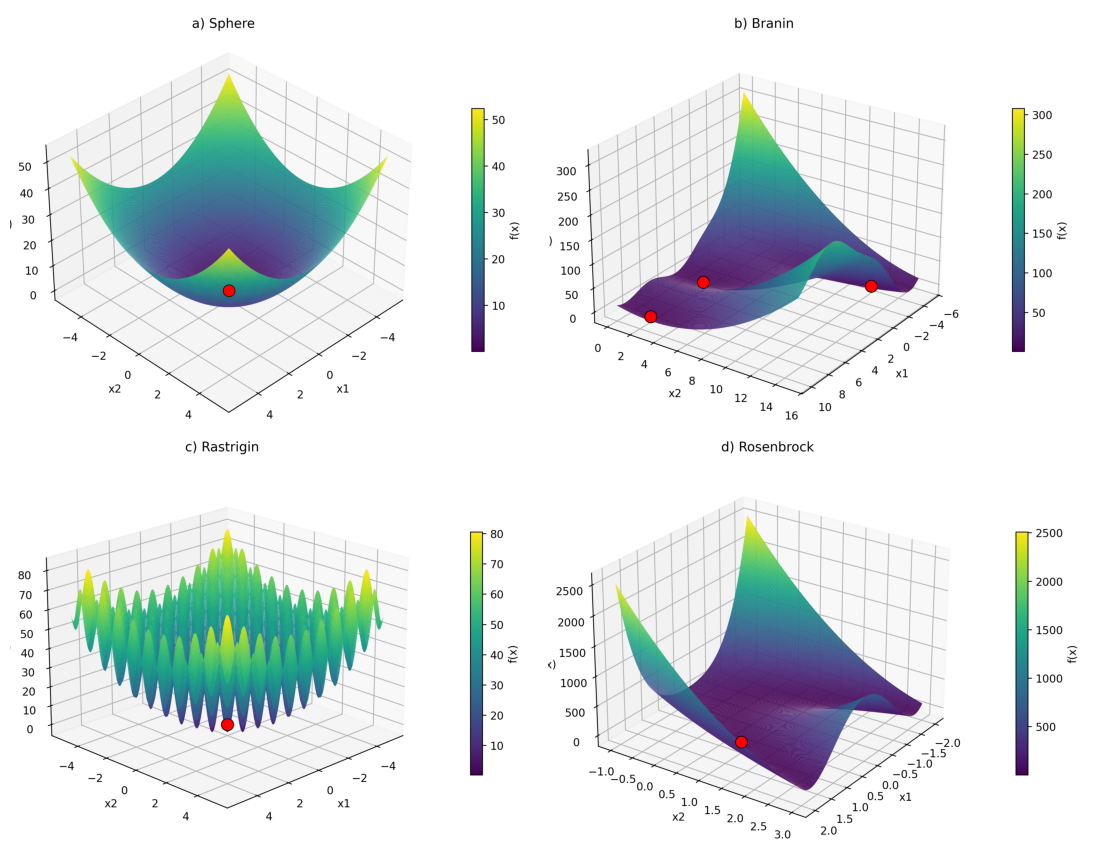

In [ ]:
# Update: thinner/no outline for minima markers and a more top-down view for Sphere.
# - Outline set to 'none' (you can switch to a thin outline by changing linewidths to 0.2 and edgecolors to 'black').
# - Sphere view set to (elev=55, azim=45) to look more from above.
#
# Where to change in the script:
#   -> function overlay_marker_in_front(...):
#        overlay.scatter(..., edgecolors='none', linewidths=0, ...)
#      (set edgecolors='black', linewidths=0.2 for a very thin outline instead)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, proj3d  # noqa: F401
from matplotlib import cm
from matplotlib.colors import Normalize
from io import BytesIO
from PIL import Image

def sphere(x, y):
    return x**2 + y**2

def rastrigin(x, y, A=10.0):
    return 2*A + (x**2 - A*np.cos(2*np.pi*x)) + (y**2 - A*np.cos(2*np.pi*y))

def rosenbrock(x, y, a=1.0, b=100.0):
    return (a - x)**2 + b*(y - x**2)**2

def branin(x, y):
    a = 1.0
    b = 5.1/(4*np.pi**2)
    c = 5/np.pi
    r = 6.0
    s = 10.0
    t = 1/(8*np.pi)
    return a*(y - b*x**2 + c*x - r)**2 + s*(1 - t)*np.cos(x) + s

def fig_to_image(fig):
    buf = BytesIO()
    fig.savefig(buf, format='png', dpi=240, bbox_inches='tight')
    plt.close(fig)
    buf.seek(0)
    return Image.open(buf).convert("RGBA")

def surface_with_z(ax, XX, YY, ZZ):
    norm = Normalize(vmin=np.nanmin(ZZ), vmax=np.nanmax(ZZ))
    cmap = cm.viridis
    colors = cmap(norm(ZZ))
    ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1,
                    facecolors=colors, linewidth=0, antialiased=True, shade=False)
    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array(ZZ)
    plt.colorbar(mappable, ax=ax, shrink=0.6, pad=0.1, label="f(x)")

from mpl_toolkits.mplot3d import proj3d

def overlay_minima_foreground(fig, ax3d, pts, size=120, face="#ff0000", edge='black', lw=0.8):
    """
    Zeichnet 2D-Marker in einem Overlay-Axis genau über den 3D-Minima.
    -> Immer sichtbar (im Vordergrund), pixelgenau projiziert.
    """
    # Layout/Projektion finalisieren
    fig.canvas.draw()
    # Gleiche Position wie das 3D-Axis
    bbox = ax3d.get_position()
    ov = fig.add_axes([bbox.x0, bbox.y0, bbox.width, bbox.height], frameon=False, zorder=10)
    ov.set_xlim(0, 1); ov.set_ylim(0, 1); ov.axis("off")

    # Projektion 3D -> 2D
    M = ax3d.get_proj()
    for (x, y, z) in pts:
        x2, y2, _ = proj3d.proj_transform(x, y, z, M)
        # Daten -> Display-Pixel -> Figure-Fraction -> Overlay-Koordinaten
        xp, yp = ax3d.transData.transform((x2, y2))
        xf, yf = fig.transFigure.inverted().transform((xp, yp))
        u = (xf - bbox.x0) / bbox.width
        v = (yf - bbox.y0) / bbox.height
        ov.scatter([u], [v], s=size, c=face, edgecolors=edge, linewidths=lw, zorder=10)


def place_min_markers_3d(ax, pts, size=140, face="#ff0000", edge='none', lw=0.0):
    # pts = list of (x, y, z)
    xs, ys, zs = zip(*pts)
    coll = ax.scatter(xs, ys, zs, s=size, c=face,
                      edgecolors=edge, linewidths=lw,
                      depthshade=False)
    # Trick: ganz nach vorne sortieren, bleibt dennoch exakt auf (x*,y*,z*)
    coll.set_sort_zpos(ax.get_zlim()[1] + 1e6)

def make_panel(title, dom, func, minima, view=None):
    xmin, xmax, ymin, ymax = dom
    g = 200
    X = np.linspace(xmin, xmax, g); Y = np.linspace(ymin, ymax, g)
    XX, YY = np.meshgrid(X, Y); ZZ = func(XX, YY)

    fig = plt.figure(figsize=(7, 5.6))
    ax = fig.add_subplot(111, projection='3d')
    surface_with_z(ax, XX, YY, ZZ)

    # 3D-Koordinaten der Minima
    mins3d = []
    for (xm, ym) in minima:
        zm = float(np.asarray(func(np.array(xm, float), np.array(ym, float))))
        mins3d.append((xm, ym, zm))

    # Achsen/Ansicht
    ax.set_title(title); ax.set_xlabel("x1"); ax.set_ylabel("x2"); ax.set_zlabel("f(x)")
    if view is not None:
        elev, azim = view; ax.view_init(elev=elev, azim=azim)

    # 1) Echte 3D-Marker exakt auf (x*,y*,z*)
    place_min_markers_3d(ax, mins3d, size=140, face="#ff0000", edge='black', lw=0.2)

    # 2) Overlay im Vordergrund (damit die Marker niemals verdeckt werden)
    fig.tight_layout()
    fig.canvas.draw()  # wichtig: Projektion/Layout finalisieren
    overlay_minima_foreground(fig, ax, mins3d, size=120, face="#ff0000", edge='black', lw=0.6)

    return fig_to_image(fig)


# Panels
img_a = make_panel("a) Sphere", (-5.12, 5.12, -5.12, 5.12), sphere, [(0.0, 0.0)], view=(35, 45))
img_b = make_panel("b) Branin", (-5.0, 10.0, 0.0, 15.0), branin,
                   [(-np.pi, 12.275), (np.pi, 2.275), (9.42478, 2.475)], view=(25, 35))
img_c = make_panel("c) Rastrigin", (-5.12, 5.12, -5.12, 5.12), rastrigin, [(0.0, 0.0)], view=(20, 45))
img_d = make_panel("d) Rosenbrock", (-2.0, 2.0, -1.0, 3.0), rosenbrock, [(1.0, 1.0)], view=(25, 35))

# Compose 2x2
def pad(im, w, h):
    canvas = Image.new("RGBA", (w, h), (255, 255, 255, 0))
    canvas.paste(im, (0, 0))
    return canvas

w = max(im.width for im in [img_a, img_b, img_c, img_d])
h = max(im.height for im in [img_a, img_b, img_c, img_d])

A = pad(img_a, w, h); B = pad(img_b, w, h); C = pad(img_c, w, h); D = pad(img_d, w, h)

grid = Image.new("RGBA", (w*2, h*2), (255, 255, 255, 0))
grid.paste(A, (0, 0));     grid.paste(B, (w, 0))
grid.paste(C, (0, h));     grid.paste(D, (w, h))

plt.figure(figsize=(16, 11))
plt.imshow(grid); plt.axis('off')
plt.show()


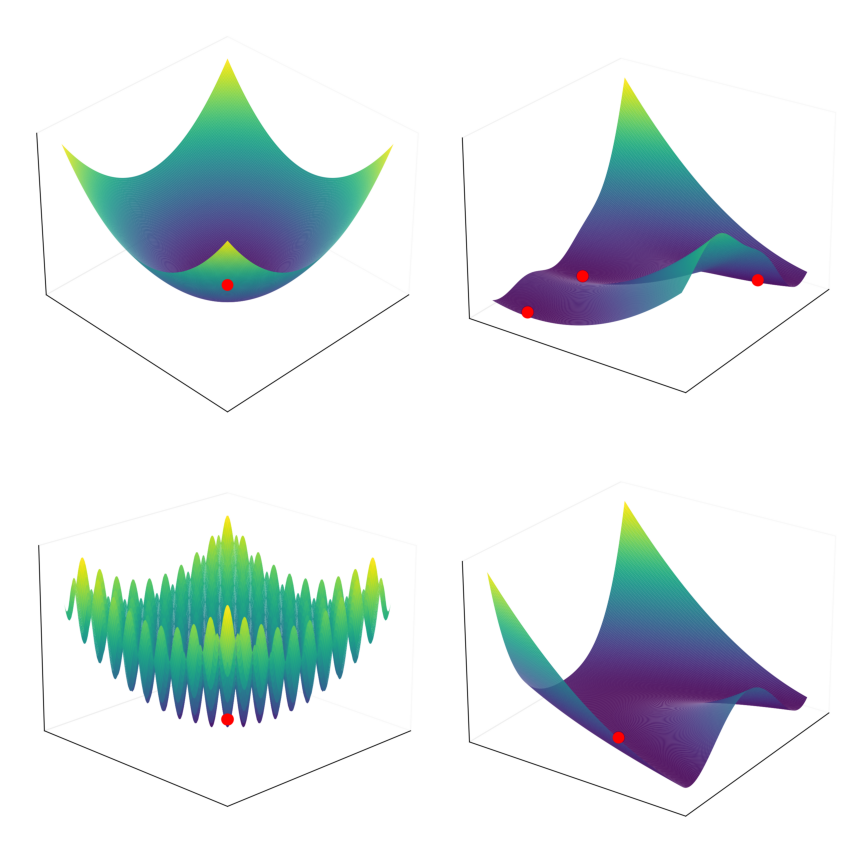

In [ ]:
# Minimal 3D panels ohne Labels/Axis/Colorbar (Marker standard: ohne Outline)
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, proj3d  # noqa: F401
from matplotlib import cm
from matplotlib.colors import Normalize
from io import BytesIO
from PIL import Image

def sphere(x, y):
    return x**2 + y**2

def rastrigin(x, y, A=10.0):
    return 2*A + (x**2 - A*np.cos(2*np.pi*x)) + (y**2 - A*np.cos(2*np.pi*y))

def rosenbrock(x, y, a=1.0, b=100.0):
    return (a - x)**2 + b*(y - x**2)**2

def branin(x, y):
    a = 1.0
    b = 5.1/(4*np.pi**2)
    c = 5/np.pi
    r = 6.0
    s = 10.0
    t = 1/(8*np.pi)
    return a*(y - b*x**2 + c*x - r)**2 + s*(1 - t)*np.cos(x) + s

def fig_to_image(fig):
    buf = BytesIO()
    fig.savefig(buf, format='png', dpi=240, bbox_inches='tight')
    plt.close(fig)
    buf.seek(0)
    return Image.open(buf).convert("RGBA")

def surface_with_z(ax, XX, YY, ZZ):
    norm = Normalize(vmin=np.nanmin(ZZ), vmax=np.nanmax(ZZ))
    colors = cm.viridis(norm(ZZ))
    ax.plot_surface(
        XX, YY, ZZ, rstride=1, cstride=1,
        facecolors=colors, linewidth=0, antialiased=True, shade=False
    )
    # Keine Colorbar, keine Labels

def strip_3d_axes(ax):
    # Alle Beschriftungen/Ticks/Titel entfernen, Pane-Füllung deaktivieren
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.set_xlabel(''); ax.set_ylabel(''); ax.set_zlabel('')
    ax.set_title('')
    try:
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
    except Exception:
        pass

def overlay_minima_foreground(fig, ax3d, pts, size=120, face="#ff0000", edge='none', lw=0.0):
    """
    2D-Overlay-Marker exakt über 3D-Minima, immer im Vordergrund.
    Setze edge='black', lw=0.2 für sehr dünne Outline.
    """
    fig.canvas.draw()
    bbox = ax3d.get_position()
    ov = fig.add_axes([bbox.x0, bbox.y0, bbox.width, bbox.height], frameon=False, zorder=10)
    ov.set_xlim(0, 1); ov.set_ylim(0, 1); ov.axis("off")

    M = ax3d.get_proj()
    for (x, y, z) in pts:
        x2, y2, _ = proj3d.proj_transform(x, y, z, M)
        xp, yp = ax3d.transData.transform((x2, y2))
        xf, yf = fig.transFigure.inverted().transform((xp, yp))
        u = (xf - bbox.x0) / bbox.width
        v = (yf - bbox.y0) / bbox.height
        ov.scatter([u], [v], s=size, c=face, edgecolors=edge, linewidths=lw, zorder=10)

def place_min_markers_3d(ax, pts, size=140, face="#ff0000", edge='none', lw=0.0):
    xs, ys, zs = zip(*pts)
    coll = ax.scatter(xs, ys, zs, s=size, c=face, edgecolors=edge, linewidths=lw, depthshade=False)
    coll.set_sort_zpos(ax.get_zlim()[1] + 1e6)

def make_panel(dom, func, minima, view=None):
    xmin, xmax, ymin, ymax = dom
    g = 200
    X = np.linspace(xmin, xmax, g); Y = np.linspace(ymin, ymax, g)
    XX, YY = np.meshgrid(X, Y); ZZ = func(XX, YY)

    fig = plt.figure(figsize=(7, 5.6))
    ax = fig.add_subplot(111, projection='3d')
    surface_with_z(ax, XX, YY, ZZ)

    mins3d = []
    for (xm, ym) in minima:
        zm = float(np.asarray(func(np.array(xm, float), np.array(ym, float))))
        mins3d.append((xm, ym, zm))

    if view is not None:
        elev, azim = view
        ax.view_init(elev=elev, azim=azim)

    # Keine Achsen-/Titel-Beschriftungen
    strip_3d_axes(ax)

    # Marker (3D + Overlay im Vordergrund), standard ohne Outline
    place_min_markers_3d(ax, mins3d, size=140, face="#ff0000", edge='none', lw=0.0)
    fig.tight_layout()
    fig.canvas.draw()
    overlay_minima_foreground(fig, ax, mins3d, size=120, face="#ff0000", edge='none', lw=0.0)

    return fig_to_image(fig)

# Panels (Sphere top-down: elev=55, azim=45)
img_a = make_panel((-5.12, 5.12, -5.12, 5.12), sphere, [(0.0, 0.0)], view=(35, 45))
img_b = make_panel((-5.0, 10.0, 0.0, 15.0), branin,
                   [(-np.pi, 12.275), ( np.pi, 2.275), (9.42478, 2.475)], view=(25, 35))
img_c = make_panel((-5.12, 5.12, -5.12, 5.12), rastrigin, [(0.0, 0.0)], view=(20, 45))
img_d = make_panel((-2.0, 2.0, -1.0, 3.0), rosenbrock, [(1.0, 1.0)], view=(25, 35))

# 2x2 Komposition als PNG
def pad(im, w, h):
    canvas = Image.new("RGBA", (w, h), (255, 255, 255, 0))
    canvas.paste(im, (0, 0))
    return canvas

w = max(im.width for im in [img_a, img_b, img_c, img_d])
h = max(im.height for im in [img_a, img_b, img_c, img_d])

A = pad(img_a, w, h); B = pad(img_b, w, h); C = pad(img_c, w, h); D = pad(img_d, w, h)

grid = Image.new("RGBA", (w*2, h*2), (255, 255, 255, 0))
grid.paste(A, (0, 0)); grid.paste(B, (w, 0))
grid.paste(C, (0, h)); grid.paste(D, (w, h))

plt.figure(figsize=(16, 11))
plt.imshow(grid); plt.axis('off')
plt.show()


## Appendix A

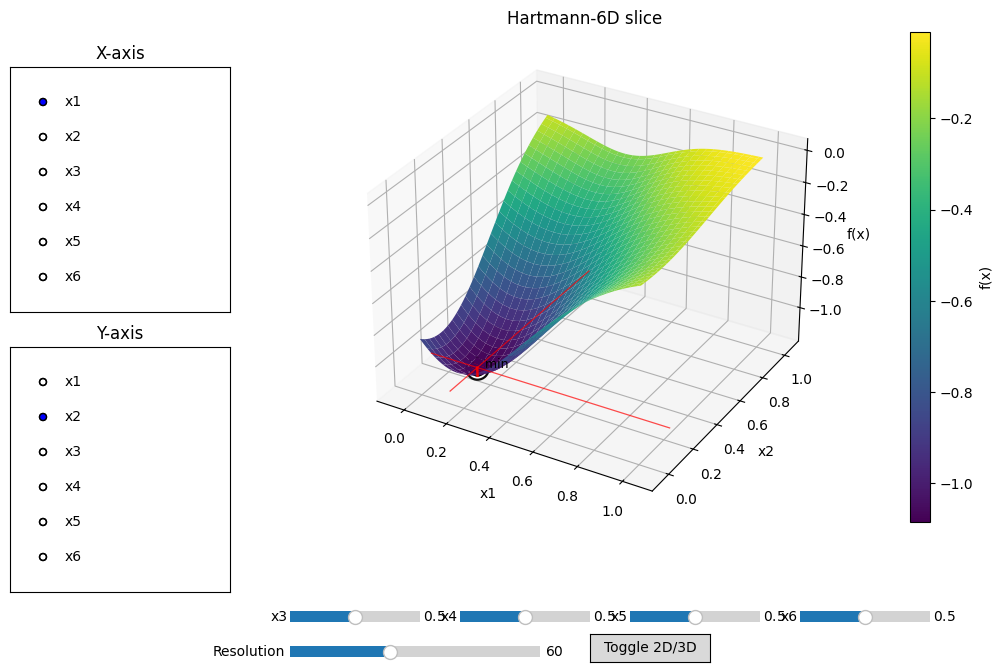

In [ ]:
# Interactive Hartmann-6D explorer (robust layout)
# - Feste Achsen-Rects (keine Layout-Verschiebungen)
# - Eine einzige Colorbar-Achse (wird nur aktualisiert)
# - Farben = f(x), Slice-Minimum markiert (3D: Halo+Linien; 2D: Stern+Halo)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from matplotlib.widgets import Slider, RadioButtons, Button
from matplotlib import cm
from matplotlib.colors import Normalize

# --- Hartmann-6D constants ---
alpha = np.array([1.0, 1.2, 3.0, 3.2])
A = np.array([
    [10, 3, 17, 3.5, 1.7, 8],
    [0.05, 10, 17, 0.1, 8, 14],
    [3, 3.5, 1.7, 10, 17, 8],
    [17, 8, 0.05, 10, 0.1, 14]
])
P = 1e-4 * np.array([
    [1312, 1696, 5569, 124, 8283, 5886],
    [2329, 4135, 8307, 3736, 1004, 9991],
    [2348, 1451, 3522, 2883, 3047, 6650],
    [4047, 8828, 8732, 5743, 1091, 381]
])

def hartmann6(x):
    x = np.atleast_2d(x)
    inner = np.empty((x.shape[0], 4))
    for i in range(4):
        diff = x - P[i]
        inner[:, i] = np.sum(A[i] * (diff ** 2), axis=1)
    return -np.sum(alpha * np.exp(-inner), axis=1)

# --- Initial settings ---
axis_labels = [f"x{i+1}" for i in range(6)]
fixed_vals = np.array([0.5]*6)
view_mode = "3D"
res = 60
cmap = cm.viridis

def compute_surface(ai, aj, fixed, n):
    grid = np.linspace(0, 1, n)
    Xi, Xj = np.meshgrid(grid, grid)
    pts = np.zeros((n*n, 6))
    for k in range(6):
        if k == ai:
            pts[:, k] = Xi.ravel()
        elif k == aj:
            pts[:, k] = Xj.ravel()
        else:
            pts[:, k] = fixed[k]
    Z = hartmann6(pts).reshape(n, n)
    idx = np.argmin(Z)
    imin, jmin = np.unravel_index(idx, Z.shape)
    return Xi, Xj, Z, (Xi[imin, jmin], Xj[imin, jmin], Z[imin, jmin])

# --- Figure & fixed axes rectangles (left, bottom, width, height) ---
plt.close('all')
fig = plt.figure(figsize=(10, 7))
# Hauptplot-Fläche (teilen sich 3D und 2D):
ax_rect = [0.28, 0.25, 0.63, 0.70]
ax3d = fig.add_axes(ax_rect, projection='3d')
ax2d = fig.add_axes(ax_rect)
ax2d.set_visible(False)  # Start in 3D

# Feste Colorbar-Achse:
cax = fig.add_axes([0.92, 0.25, 0.02, 0.70])  # schmale CB rechts

# Widgets-Bereiche links/unten (fix):
rax1 = fig.add_axes([0.02, 0.55, 0.22, 0.35])  # Radio X
radio_x = RadioButtons(rax1, axis_labels, active=0)
rax1.set_title("X-axis")

rax2 = fig.add_axes([0.02, 0.15, 0.22, 0.35])  # Radio Y
radio_y = RadioButtons(rax2, axis_labels, active=1)
rax2.set_title("Y-axis")

slider_objs = []
for i in range(4):
    ax_sl = fig.add_axes([0.30 + (i*0.17), 0.10, 0.13, 0.03])
    s = Slider(ax_sl, f"x?", 0.0, 1.0, valinit=0.5)
    slider_objs.append(s)

ax_res = fig.add_axes([0.30, 0.05, 0.25, 0.03])
res_slider = Slider(ax_res, "Resolution", 20, 120, valinit=res, valstep=10)

ax_btn = fig.add_axes([0.60, 0.05, 0.12, 0.04])
toggle_btn = Button(ax_btn, "Toggle 2D/3D")

# --- Colorbar: erstellen EINMAL, dann nur updaten ---
norm = Normalize(0, 1)
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
colorbar = fig.colorbar(mappable, cax=cax)
colorbar.set_label("f(x)")

# Slider→Dim Mapping
slider_dim_indices = []

def active_ax():
    return ax3d if view_mode == "3D" else ax2d

def refresh_slider_mapping():
    global slider_dim_indices
    ai = axis_labels.index(radio_x.value_selected)
    aj = axis_labels.index(radio_y.value_selected)
    other_dims = [i for i in range(6) if i not in (ai, aj)]
    slider_dim_indices = other_dims  # exakt 4
    # Labels setzen; Werte NICHT programmgesteuert ändern (damit Interaktivität sauber bleibt)
    for s, dim in zip(slider_objs, slider_dim_indices):
        s.label.set_text(axis_labels[dim])

def read_sliders_into_fixed_vals():
    for s, dim in zip(slider_objs, slider_dim_indices):
        fixed_vals[dim] = s.val

# --- Neuer: auffälliger Min-Punkt (2D/3D) ---
def draw_min_marker(ax, xi_min, xj_min, z_min=None, view="3D"):
    """
    Zeichnet einen gut sichtbaren Min-Punkt:
    - 3D: weißer Halo (+ schwarze Kontur) + roter Kern, vertikale Linie zum Boden,
          Kreuzlinien in X/Y auf Höhe z_min, kleines Label.
    - 2D: weißer Kreis-Halo + roter Stern mit schwarzer Kontur, doppelte Kreuzlinien,
          kleines Label.
    """
    if view == "3D":
        # Halo (weiß, mit schwarzer Kontur) + roter Kern
        ax.scatter([xi_min], [xj_min], [z_min], s=260, c="white",
                   edgecolors="k", linewidths=1.6, alpha=0.95, zorder=6, depthshade=False)
        ax.scatter([xi_min], [xj_min], [z_min], s=120, c="red",
                   edgecolors="k", linewidths=0.9, alpha=1.00, zorder=7, depthshade=False)

        # Vertikale Linie zum unteren z-Limit
        z0 = ax.get_zlim()[0]
        ax.plot([xi_min, xi_min], [xj_min, xj_min], [z0, z_min],
                color="red", linewidth=1.8, alpha=0.9, zorder=5)

        # Kreuzlinien auf Höhe z_min
        xlo, xhi = ax.get_xlim()
        ylo, yhi = ax.get_ylim()
        ax.plot([xlo, xhi], [xj_min, xj_min], [z_min, z_min],
                color="red", linewidth=0.9, alpha=0.7, zorder=5)
        ax.plot([xi_min, xi_min], [ylo, yhi], [z_min, z_min],
                color="red", linewidth=0.9, alpha=0.7, zorder=5)

        # Label
        ax.text(xi_min, xj_min, z_min, "  min", color="k", fontsize=9, zorder=8)
    else:
        # Weißer Kreis-Halo
        ax.scatter([xi_min], [xj_min], s=300, c="white",
                   edgecolors="k", linewidths=1.4, alpha=0.95, zorder=6)
        # Roter Stern mit schwarzer Kontur
        ax.scatter([xi_min], [xj_min], s=160, c="red", marker="*",
                   edgecolors="k", linewidths=0.9, zorder=7)

        # Kreuz-Hilfslinien: Halo (weiß, dick) + rot obenauf
        ax.axvline(x=xi_min, color="white", linewidth=2.6, alpha=0.9, zorder=4)
        ax.axhline(y=xj_min, color="white", linewidth=2.6, alpha=0.9, zorder=4)
        ax.axvline(x=xi_min, color="red",   linewidth=1.2, alpha=0.95, zorder=5)
        ax.axhline(y=xj_min, color="red",   linewidth=1.2, alpha=0.95, zorder=5)

        # Label
        ax.text(xi_min, xj_min, " min", color="k", fontsize=9, zorder=8)

def redraw(*args):
    # Sichtbarkeit fest
    ax3d.set_visible(view_mode == "3D")
    ax2d.set_visible(view_mode == "2D")

    ax = active_ax()
    ax.cla()  # nur Inhalt löschen, nicht die Achse austauschen

    ai = axis_labels.index(radio_x.value_selected)
    aj = axis_labels.index(radio_y.value_selected)
    if ai == aj:
        ax.text(0.5, 0.5, "Choose different axes for X and Y",
                ha='center', va='center', transform=ax.transAxes)
        fig.canvas.draw_idle()
        return

    read_sliders_into_fixed_vals()
    Xi, Xj, Z, (xi_min, xj_min, z_min) = compute_surface(ai, aj, fixed_vals, int(res_slider.val))

    # Norm & Colorbar updaten (keine neue Colorbar anlegen!)
    norm.vmin, norm.vmax = float(np.nanmin(Z)), float(np.nanmax(Z))
    mappable.set_norm(norm)
    colorbar.update_normal(mappable)  # skaliert die bestehende CB neu

    if view_mode == "3D":
        ax.plot_surface(
            Xi, Xj, Z,
            facecolors=cmap(norm(Z)),
            linewidth=0, antialiased=True,
            shade=False
        )
        # Deutlich sichtbarer Min-Punkt
        draw_min_marker(ax, xi_min, xj_min, z_min, view="3D")
        ax.set_zlabel("f(x)")
    else:
        ax.contourf(Xi, Xj, Z, levels=30, cmap=cmap, norm=norm)
        # Deutlich sichtbarer Min-Punkt
        draw_min_marker(ax, xi_min, xj_min, view="2D")

    ax.set_xlabel(axis_labels[ai])
    ax.set_ylabel(axis_labels[aj])
    ax.set_title("Hartmann-6D slice")
    fig.canvas.draw_idle()

def on_radio_x(label):
    refresh_slider_mapping()
    redraw()

def on_radio_y(label):
    refresh_slider_mapping()
    redraw()

def on_slider_change(val):
    redraw()

def on_res_change(val):
    redraw()

def on_toggle(event):
    global view_mode
    view_mode = "2D" if view_mode == "3D" else "3D"
    redraw()

# Events verbinden
radio_x.on_clicked(on_radio_x)
radio_y.on_clicked(on_radio_y)
for s in slider_objs:
    s.on_changed(on_slider_change)
res_slider.on_changed(on_res_change)
toggle_btn.on_clicked(on_toggle)

# Initialisierung
refresh_slider_mapping()
redraw()
plt.show()